## Model prediction and Result analysis
I use this Notebook to evaluate the output(final and intermediate) of the trained models

In [1]:
import torch, sys
sys.path.append('../src/')
import constants
import prediction as P
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from pathlib import Path
import argparse
device = "cuda" if torch.cuda.is_available() else "cpu" 
from models import MultiTaskModel 

device = 'cuda' if torch.cuda.is_available() else "cpu"


/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load model

In [2]:
nntype = "biomedclip"
visual_branch_only = False
backbone_v = None
high_order = "binary"
no_orthogonize = True
no_contrastive = True
model = MultiTaskModel(nntype = nntype, visual_branch_only=visual_branch_only,backbone_v = backbone_v,high_order=high_order, 
                        no_orthogonize = no_orthogonize, no_contrastive=no_contrastive, )

in current image branch, the vis backbone for vis embedding is: biomedclip
in current Text branch, the text backbone for text embedding is: biomedclip


In [2]:
def load_mode(bypass = False):
  """
  param: basspass: bool, default-False
  return: model
  """
  if bypass :
    model_path = '/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/biovil-t_None_False_False_binary_False_False_NA/pytorch_model.bin'
  else:
    model_path = input("Please enter your model path: ")
  config_dict = P.parse_model_path(model_path)

  backbone = "biomedclip" if config_dict['backbone'] == None else config_dict['backbone']
  backbone_v = None if config_dict['backbone_v'] == None else config_dict['backbone_v']
  visual_branch_only = config_dict['v_only']
  no_orthogonize = config_dict['no_orthogonize']
  if no_orthogonize:
    print(constants.RED + "do not implement orthogonization" + constants.RESET)
  no_contrastive = config_dict['no_contrastive']
  if no_contrastive:
    print(constants.RED + "do not implement contrastive learning between text and images" + constants.RESET)
  high_order = config_dict['high_order']
  if high_order != "NA":
    print(constants.RED+f"integrate graph alignment into the whole loss, using {high_order} graph!"+constants.RESET)
  model = P.load_model(model_path, nntype = backbone, visual_branch_only = visual_branch_only, backbone_v = backbone_v,
                          high_order=high_order, no_orthogonize = no_orthogonize, no_contrastive=no_contrastive, )
# model_infer_eval(model, backbone_type = backbone, dump_path=dump)
  return model

model = load_mode(True)

['biovil-t', 'None', 'False', 'False', 'binary', 'False', 'False', 'NA']
 backbone : biovil-t
 backbone_v : None
 v_only : False
 learnable_weight : False
 high_order : binary
 no_orthogonize : False
 no_contrastive : False
 weight_strategy : NA
integrate graph alignment into the whole loss, using binary graph!
in current image branch, the vis backbone for vis embedding is: biovil-t


/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


in current Text branch, the text backbone for text embedding is: biovil-t


In [12]:
import pandas as pd

temp = pd.read_csv("/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/mimic-cxr-train/P10_12_test_1_29_labels14_biovil.csv", index_col = 0)
temp.head(1)#.Biovil_img_tensor_path[0]

,label,img_path,train_label,file_path,split,BiomedClip_img_tensor_path,Clip_img_tensor_path,sid,test_14_labels,Biomed_img_tensor_path,Biovil_img_tensor_path
Unnamed: 0,,,,,,,,,,,
0,"{'Atelectasis': 1, 'Cardiomegaly': 1, 'Consoli...",D:/project_x_ray_CLIP/data/physionet.org/files...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",D:/project_x_ray_CLIP/data/physionet.org/files...,test,/public_bme/data/lds/p10/p10032725/s50331901/6...,/public_bme/data/lds/p10/p10032725/s50331901/6...,50331901,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0]",/public_bme/data/lds/p10/p10032725/s50331901/6...,/public_bme/data/lds/p10/p10032725/s50331901/6...


In [24]:
def get_model_image_embedding(model = None):  
  dump_prompt = []
  dump_label = [[[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0],]]
  img = [r'/public_bme/data/lds/p10/p10032725/s50331901/687754ce-7420bfd3-0a19911f-a27a3916-9019cd53_biovil.pth']
  output = model(dump_prompt, img = img, img_labels  = dump_label, eval = True)
  return output[0]['img_embeds']

image_embedding = get_model_image_embedding(model)


['/public_bme/data/lds/p10/p10032725/s50331901/687754ce-7420bfd3-0a19911f-a27a3916-9019cd53_biovil.pth']


torch.Size([1, 14, 128])

### `PCA` and `UMAP` visualization

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/matplotlib/text.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-packages/matplotlib/text.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/home_data/home/v-liudsh/miniconda3/envs/hi-ml-multimoda/lib/python3.8/site-package

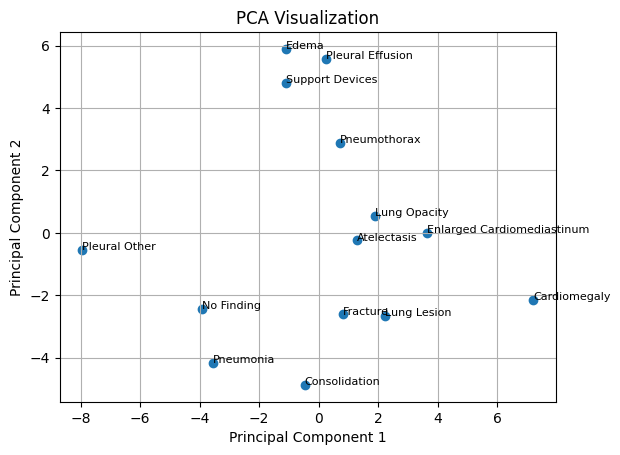

In [38]:
def plot_pca(data):
  labels = constants.CHEXPERT_TASKS
  scaler = StandardScaler()
  data_standardized = scaler.fit_transform(data)

  cov_matrix = np.cov(data_standardized, rowvar=False)

  # Step 3: Compute the eigenvectors and eigenvalues
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

  # Step 4: Select the top 2 eigenvectors
  top_eigenvectors = eigenvectors[:, :2]

  # Step 5: Project the data onto the principal components
  data_2d = np.dot(data_standardized, top_eigenvectors)

  # Plot the 2D representation of the data
  plt.scatter(data_2d[:, 0], data_2d[:, 1])
  for i, label in enumerate(labels):
    plt.text(data_2d[i, 0], data_2d[i, 1], str(label), fontsize=8)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title('PCA Visualization')
  plt.grid()
  plt.show()
  
plot_pca(image_embedding[0].detach().numpy())


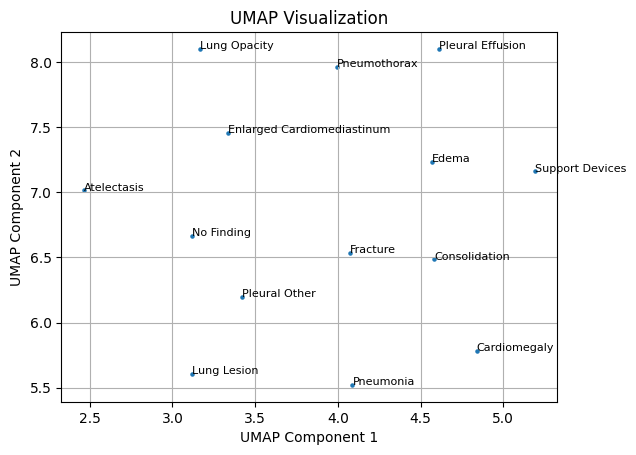

In [46]:
import numpy as np

import matplotlib.pyplot as plt

# Generate random data
n = 14
m = 10
data = np.random.rand(n, m)

def plot_UMAP(data):
  n, m = data.shape
  labels = constants.CHEXPERT_TASKS
  
  # Apply UMAP to reduce the dimensionality of the data to 2 dimensions
  reducer = umap.UMAP(n_neighbors = n-1)
  embedding = reducer.fit_transform(data)

  # Visualize the data
  plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
  for i, label in enumerate(labels):
    plt.text(embedding[i, 0], embedding[i, 1], str(label), fontsize=8)
  plt.title('UMAP Visualization')
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')
  plt.grid()
  plt.show()
  
plot_UMAP(image_embedding[0].detach().numpy())
